<a href="https://colab.research.google.com/github/eshal26/Leukemia-classification/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip Original.zip

Archive:  Original.zip
   creating: Original/Benign/
  inflating: Original/Benign/WBC-Benign-001.jpg  
  inflating: Original/Benign/WBC-Benign-002.jpg  
  inflating: Original/Benign/WBC-Benign-003.jpg  
  inflating: Original/Benign/WBC-Benign-004.jpg  
  inflating: Original/Benign/WBC-Benign-005.jpg  
  inflating: Original/Benign/WBC-Benign-006.jpg  
  inflating: Original/Benign/WBC-Benign-007.jpg  
  inflating: Original/Benign/WBC-Benign-008.jpg  
  inflating: Original/Benign/WBC-Benign-009.jpg  
  inflating: Original/Benign/WBC-Benign-010.jpg  
  inflating: Original/Benign/WBC-Benign-011.jpg  
  inflating: Original/Benign/WBC-Benign-012.jpg  
  inflating: Original/Benign/WBC-Benign-013.jpg  
  inflating: Original/Benign/WBC-Benign-014.jpg  
  inflating: Original/Benign/WBC-Benign-015.jpg  
  inflating: Original/Benign/WBC-Benign-016.jpg  
  inflating: Original/Benign/WBC-Benign-017.jpg  
  inflating: Original/Benign/WBC-Benign-018.jpg  
  inflating: Original/Benign/WBC-Benign-019.jpg

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split
import shutil

# Define paths to your dataset directories
dataset_dir = 'Original'
benign_dir = os.path.join(dataset_dir, 'Benign')
malignant_dir = os.path.join(dataset_dir, 'Malignant')  # Create this directory if it doesn't exist

# Create the malignant directory if it doesn't exist
if not os.path.exists(malignant_dir):
    os.makedirs(malignant_dir)

# Move images from early, pre, and pro directories to malignant directory
for stage in ['Early', 'Pre', 'Pro']:
    stage_dir = os.path.join(dataset_dir, stage)
    for img_file in os.listdir(stage_dir):
        img_path = os.path.join(stage_dir, img_file)
        shutil.move(img_path, malignant_dir)

# Update dataset directory structure and labels
os.rmdir(os.path.join(dataset_dir, 'Early'))
os.rmdir(os.path.join(dataset_dir, 'Pre'))
os.rmdir(os.path.join(dataset_dir, 'Pro'))

In [3]:
from sklearn.model_selection import train_test_split

# Define paths to your original dataset directory
original_data_dir = 'Original'
benign_dir = os.path.join(original_data_dir, 'Benign')
malignant_dir = os.path.join(original_data_dir, 'Malignant')

# Define paths to create directories for the new dataset splits
train_dir = 'train_dataset'
val_dir = 'validation_dataset'
test_dir = 'test_dataset'

# Create directories for the new dataset splits if they don't exist
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    for category in ['Benign', 'Malignant']:
        os.makedirs(os.path.join(directory, category), exist_ok=True)

# Split dataset and copy images to appropriate directories
for category_dir, category in [(benign_dir, 'Benign'), (malignant_dir, 'Malignant')]:
    image_files = [os.path.join(category_dir, img) for img in os.listdir(category_dir)]
    train_files, test_val_files = train_test_split(image_files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

    for file in train_files:
        shutil.copy(file, os.path.join(train_dir, category))
    for file in val_files:
        shutil.copy(file, os.path.join(val_dir, category))
    for file in test_files:
        shutil.copy(file, os.path.join(test_dir, category))


In [14]:
# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
data_dir = {
    'train': 'train_dataset',
    'val': 'validation_dataset',
    'test': 'test_dataset'
}

image_datasets = {x: datasets.ImageFolder(data_dir[x], data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes


In [15]:
# Load VGG model
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_acc_history = []
    val_acc_history = []
    val_precision_history = []
    val_recall_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_precision = precision_score(all_labels, all_preds, average='weighted')
            epoch_recall = recall_score(all_labels, all_preds, average='weighted')
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1-score: {epoch_f1:.4f}')

            if phase == 'train':
                train_acc_history.append(epoch_acc)
            else:
                val_acc_history.append(epoch_acc)
                val_precision_history.append(epoch_precision)
                val_recall_history.append(epoch_recall)
                val_f1_history.append(epoch_f1)

    return model, train_acc_history, val_acc_history, val_precision_history, val_recall_history, val_f1_history

model_ft, train_acc_history, val_acc_history, val_precision_history, val_recall_history, val_f1_history = train_model(model_ft, criterion, optimizer, dataloaders, num_epochs=15)


Epoch 0/14
----------
train Loss: 0.3273 Acc: 0.8671 Precision: 0.8480 Recall: 0.8671 F1-score: 0.8436
val Loss: 0.1416 Acc: 0.9538 Precision: 0.9547 Recall: 0.9538 F1-score: 0.9509
Epoch 1/14
----------
train Loss: 0.1176 Acc: 0.9566 Precision: 0.9558 Recall: 0.9566 F1-score: 0.9561
val Loss: 0.1143 Acc: 0.9692 Precision: 0.9703 Recall: 0.9692 F1-score: 0.9678
Epoch 2/14
----------
train Loss: 0.0694 Acc: 0.9720 Precision: 0.9716 Recall: 0.9720 F1-score: 0.9717
val Loss: 0.1451 Acc: 0.9508 Precision: 0.9506 Recall: 0.9508 F1-score: 0.9479
Epoch 3/14
----------
train Loss: 0.0967 Acc: 0.9589 Precision: 0.9581 Recall: 0.9589 F1-score: 0.9583
val Loss: 0.1085 Acc: 0.9600 Precision: 0.9618 Recall: 0.9600 F1-score: 0.9575
Epoch 4/14
----------
train Loss: 0.0457 Acc: 0.9835 Precision: 0.9834 Recall: 0.9835 F1-score: 0.9834
val Loss: 0.0334 Acc: 0.9877 Precision: 0.9879 Recall: 0.9877 F1-score: 0.9875
Epoch 5/14
----------
train Loss: 0.0349 Acc: 0.9866 Precision: 0.9865 Recall: 0.9866 F1-s

Test Loss: 0.0008
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1-score: 1.0000
Confusion Matrix:
 [[ 51   0]
 [  0 276]]


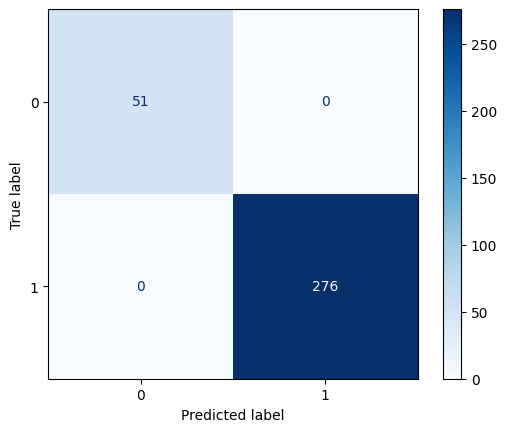

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00       276

    accuracy                           1.00       327
   macro avg       1.00      1.00      1.00       327
weighted avg       1.00      1.00      1.00       327



In [17]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_model_with_detailed_metrics(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss /= len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Print classification report
    class_report = classification_report(all_labels, all_preds)
    print("Classification Report:\n", class_report)

    return test_loss, accuracy, precision, recall, f1, cm, class_report

test_loss, test_accuracy, test_precision, test_recall, test_f1, cm, class_report = evaluate_model_with_detailed_metrics(model_ft, dataloaders['test'], criterion, device)


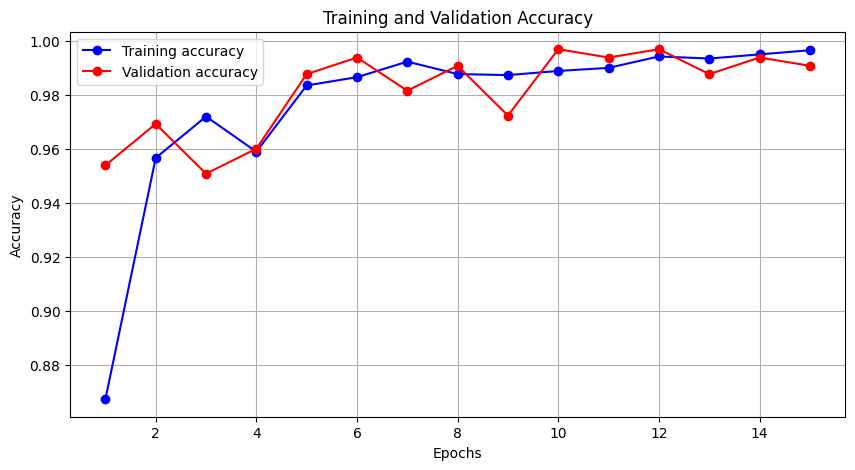

In [18]:
import matplotlib.pyplot as plt

def plot_training_results(train_acc_history, val_acc_history):
    train_acc_history = [x.cpu().numpy() for x in train_acc_history]
    val_acc_history = [x.cpu().numpy() for x in val_acc_history]

    epochs = range(1, len(train_acc_history) + 1)

    plt.figure(figsize=(10, 5))

    # Plot training and validation accuracy
    plt.plot(epochs, train_acc_history, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc_history, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Assuming train_acc_history and val_acc_history are already defined
plot_training_results(train_acc_history, val_acc_history)
